# Quick introduction

First we need to instantiate the erddapy server object.

In [1]:
from erddapy import ERDDAP


e = ERDDAP(
    server='https://data.ioos.us/gliders/erddap',
    protocol='tabledap',
    response='csv',
)

Now we can populate the object with constraints, the variables of interest, and the dataset id.

In [2]:
e.dataset_id = 'whoi_406-20160902T1700'

e.constraints = {
    'time>=': '2016-07-10T00:00:00Z',
    'time<=': '2017-02-10T00:00:00Z',
    'latitude>=': 38.0,
    'latitude<=': 41.0,
    'longitude>=': -72.0,
    'longitude<=': -69.0,
}

e.variables = [
    'depth',
    'latitude',
    'longitude',
    'salinity',
    'temperature',
    'time',
]


url = e.get_download_url()

print(url)

https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.csv?depth,latitude,longitude,salinity,temperature,time&time>=1468108800.0&time<=1486684800.0&latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0


In [3]:
import pandas as pd


df = e.to_pandas(
    index_col='time (UTC)',
    parse_dates=True,
).dropna()

df.head()

,depth (m),latitude (degrees_north),longitude (degrees_east),salinity (1),temperature (Celsius)
time (UTC),,,,,
2016-09-03 20:15:46,5.35,40.990881,-71.12439,32.245422,20.6620
2016-09-03 20:15:46,6.09,40.990881,-71.12439,32.223183,20.6512
2016-09-03 20:15:46,6.72,40.990881,-71.12439,32.237950,20.6047
2016-09-03 20:15:46,7.37,40.990881,-71.12439,32.235470,20.5843
2016-09-03 20:15:46,8.43,40.990881,-71.12439,32.224503,20.5691


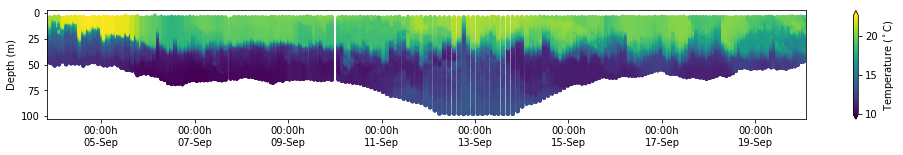

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth (m)'], s=15,
                c=df['temperature (Celsius)'], marker='o', edgecolor='none')

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)');

# Longer introduction


First we need to instantiate the `ERDDAP` URL constructor for a server.
In this example we will use [https://data.ioos.us/gliders/erddap](https://data.ioos.us/gliders/erddap).

In [5]:
from erddapy import ERDDAP


e = ERDDAP(server='https://data.ioos.us/gliders/erddap')

What are the methods/attributes available?

In [6]:
[method for method in dir(e) if not method.startswith('_')]

['constraints',
 'dataset_id',
 'get_categorize_url',
 'get_download_url',
 'get_info_url',
 'get_search_url',
 'get_var_by_attr',
 'params',
 'protocol',
 'requests_kwargs',
 'response',
 'server',
 'to_iris',
 'to_pandas',
 'to_xarray',
 'variables']

All the `get_<methods>` will return a valid `ERDDAP` URL for the requested response and options.
`erddapy` will raise an error is if URL HEADER cannot be validated.

In [7]:
print(e.get_search_url(search_for='all'))

https://data.ioos.us/gliders/erddap/search/advanced.html?page=1&itemsPerPage=1000&protocol=(ANY)&cdm_data_type=(ANY)&institution=(ANY)&ioos_category=(ANY)&keywords=(ANY)&long_name=(ANY)&standard_name=(ANY)&variableName=(ANY)&minLon=(ANY)&maxLon=(ANY)&minLat=(ANY)&maxLat=(ANY)&minTime=(ANY)&maxTime=(ANY)&searchFor=all


There are many responses available, see the docs for [griddap](https://coastwatch.pfeg.noaa.gov/erddap/griddap/documentation.html) and
[tabledap](https://coastwatch.pfeg.noaa.gov/erddap/tabledap/documentation.html) respectively.
The most useful ones for Pythonistas are the `.csv` and `.nc` that can be read with pandas and netCDF4-python respectively.

Let's load the `csv` reponse directly with `pandas`.

In [8]:
import pandas as pd


df = pd.read_csv(e.get_search_url(response='csv', search_for='all'))

In [9]:
print(
    f'We have {len(set(df["tabledap"].dropna()))} '
    f'tabledap, {len(set(df["griddap"].dropna()))} '
    f'griddap, and {len(set(df["wms"].dropna()))} wms endpoints.'
)

We have 482 tabledap, 0 griddap, and 0 wms endpoints.


We can refine our search by providing some constraints.

In [10]:
def show_iframe(src):
    """Helper function to show HTML returns."""
    from IPython.display import HTML
    iframe = f'<iframe src="{src}" width="100%" height="950"></iframe>'
    return HTML(iframe)

Let's narrow the search area, time span, and look for `sea_water_temperature` only.

In [11]:
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': -72.0,
    'max_lon': -69.0,
    'min_lat': 38.0,
    'max_lat': 41.0,
    'min_time': '2016-07-10T00:00:00Z',
    'max_time': '2017-02-10T00:00:00Z',
    'cdm_data_type': 'trajectoryprofile'
}

search_url = e.get_search_url(response='html', **kw)

show_iframe(search_url)

/home/filipe/miniconda3/envs/ERDDAPY/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


We can see that the search form above was correctly populated with the constraints we provided.

Let us change the response from `.html` to `.csv`,
so we load it as a `pandas.DataFrame`,
and inspect what are the `Dataset ID`s available for download.

In [12]:
search_url = e.get_search_url(response='csv', **kw)
search = pd.read_csv(search_url)
gliders = search['Dataset ID'].values

gliders_list = '\n'.join(gliders)
print(f'Found {len(gliders)} Glider Datasets:\n{gliders_list}')

Found 16 Glider Datasets:
blue-20160818T1448
cp_335-20170116T1459
cp_336-20161011T0027
cp_336-20170116T1254
cp_340-20160809T0230
cp_374-20160529T0035
cp_374-20161011T0106
cp_376-20160527T2050
cp_379-20170116T1246
cp_380-20161011T2046
cp_387-20160404T1858
cp_388-20160809T1409
cp_389-20161011T2040
silbo-20160413T1534
sp022-20170209T1616
whoi_406-20160902T1700


Now that we know the `Dataset ID`s we can explore their metadata with the `get_info_url` method.

In [13]:
info_url = e.get_info_url(dataset_id=gliders[0], response='html')

show_iframe(src=info_url)

Again, with the `csv` response, we can manipulate the metadata and find the variables that have the `cdm_profile_variables` attribute.

In [14]:
info_url = e.get_info_url(dataset_id=gliders[0], response='csv')

info = pd.read_csv(info_url)

info.head()

,Row Type,Variable Name,Attribute Name,Data Type,Value
0,attribute,NC_GLOBAL,acknowledgement,String,This deployment supported by NOAA U.S. IOOS
1,attribute,NC_GLOBAL,cdm_data_type,String,TrajectoryProfile
2,attribute,NC_GLOBAL,cdm_profile_variables,String,"time_uv,lat_uv,lon_uv,u,v,profile_id,time,lati..."
3,attribute,NC_GLOBAL,cdm_trajectory_variables,String,"trajectory,wmo_id"
4,attribute,NC_GLOBAL,comment,String,Glider deployed by the University of Massachus...


In [15]:
''.join(info.loc[info['Attribute Name'] == 'cdm_profile_variables', 'Value'])

'time_uv,lat_uv,lon_uv,u,v,profile_id,time,latitude,longitude'

Selecting variables by theirs attributes is such a common operation that `erddapy` brings its own method to simplify this task.

The `get_var_by_attr` method is inspired by `netCDF4-python`'s `get_variables_by_attributes` however, because `erddapy` is operating on remote serves, it will return the variable names instead of the actual variables.

Here we check what is/are the variable(s) associated with the `standard_name` used in the search.

Note that `get_var_by_attr` caches the last response in case the user needs to make multiple requests,
but it will loose its state when a new request is made.

(See the execution times below.)

In [16]:
%%time

# First one, slow.
e.get_var_by_attr(
    dataset_id='whoi_406-20160902T1700',
    standard_name='sea_water_temperature'
)

CPU times: user 220 ms, sys: 1.9 ms, total: 222 ms
Wall time: 1.75 s


['temperature']

In [17]:
%%time

# Second one on the same glider, a little bit faster.
e.get_var_by_attr(
    dataset_id='whoi_406-20160902T1700',
    standard_name='sea_water_practical_salinity'
)

CPU times: user 17.6 ms, sys: 1.94 ms, total: 19.6 ms
Wall time: 982 ms


['salinity']

In [18]:
%%time

# New one, slow again.
e.get_var_by_attr(
    dataset_id='cp_336-20170116T1254',
    standard_name='sea_water_practical_salinity'
)

CPU times: user 178 ms, sys: 5.53 ms, total: 184 ms
Wall time: 2.32 s


['salinity']

Another way to browse datasets is via the `categorize` URL. In the example below we can get all the `standard_names` available in the dataset with a single request.

In [19]:
url = e.get_categorize_url(categorize_by='standard_name', response='csv')

pd.read_csv(url)['Category']

0                                             _null
1                          conductivity_status_flag
2                               density_status_flag
3                                             depth
4                                 depth_status_flag
5                       eastward_sea_water_velocity
6           eastward_sea_water_velocity_status_flag
7                                          latitude
8                              latitude_status_flag
9                                         longitude
10                            longitude_status_flag
11                         north_sea_water_velocity
12                     northward_sea_water_velocity
13         northward_sea_water_velocity_status_flag
14                                         pressure
15                             pressure_status_flag
16                             salinity_status_flag
17                                sea_water_density
18                    sea_water_density_status_flag
19          

We can also pass a `value` to filter the categorize results.

In [20]:
url = e.get_categorize_url(
    categorize_by='institution',
    value='woods_hole_oceanographic_institution',
    response='csv'
)

df = pd.read_csv(url)

In [21]:
whoi_gliders = df.loc[~df['tabledap'].isnull(), 'Dataset ID'].tolist()

whoi_gliders

['sp007-20170427T1652',
 'sp010-20150409T1524',
 'sp010-20170707T1647',
 'sp010-20180620T1455',
 'sp022-20170209T1616',
 'sp022-20170802T1414',
 'sp022-20180124T1514',
 'sp022-20180422T1229',
 'sp022-20180912T1553',
 'sp055-20150716T1359',
 'sp062-20171116T1557',
 'sp065-20151001T1507',
 'sp065-20180310T1828',
 'sp065-20181015T1349',
 'sp066-20151217T1624',
 'sp066-20160818T1505',
 'sp066-20170416T1744',
 'sp066-20171129T1616',
 'sp066-20180629T1411',
 'sp069-20170907T1531',
 'sp069-20180411T1516',
 'whoi_406-20160902T1700']

Now it is easy to filter non WHOI gliders from our original glider search.

In [22]:
gliders = [glider for glider in gliders if glider in whoi_gliders]
gliders

['sp022-20170209T1616', 'whoi_406-20160902T1700']

With Python it is easy to loop over all the `dataset_id`s for the variables with `standard_names`

In [23]:
variables = [
    e.get_var_by_attr(
        dataset_id=glider,
        standard_name=lambda v: v is not None
    )
    for glider in gliders
]

We can construct a `set` with the common variables in those `dataset_id`s.

In [24]:
common_variables = set(variables[0]).intersection(*variables[1:])

common_variables

{'conductivity',
 'conductivity_qc',
 'density',
 'density_qc',
 'depth',
 'depth_qc',
 'lat_uv',
 'lat_uv_qc',
 'latitude',
 'latitude_qc',
 'lon_uv',
 'lon_uv_qc',
 'longitude',
 'longitude_qc',
 'precise_lat',
 'precise_lon',
 'precise_time',
 'precise_time_qc',
 'pressure',
 'pressure_qc',
 'salinity',
 'salinity_qc',
 'temperature',
 'temperature_qc',
 'time',
 'time_qc',
 'time_uv',
 'time_uv_qc',
 'u',
 'u_qc',
 'v',
 'v_qc'}

Last, but not least, the download endpoint!

It is important to note that the download constraints are based on the variables names and not the standardized ones for the `get_search_url` method.

In [25]:
constraints = {
    'longitude>=': kw['min_lon'],
    'longitude<=': kw['max_lon'],
    'latitude>=': kw['min_lat'],
    'latitude<=': kw['max_lat'],
    'time>=': kw['min_time'],
    'time<=': kw['max_time'],
}



download_url = e.get_download_url(
    dataset_id=gliders[0],
    protocol='tabledap',
    variables=common_variables,
    constraints=constraints
)

print(download_url)

https://data.ioos.us/gliders/erddap/tabledap/sp022-20170209T1616.html?precise_lon,longitude,temperature_qc,latitude,precise_lat,density_qc,u,pressure_qc,density,lat_uv,precise_time_qc,precise_time,temperature,conductivity_qc,latitude_qc,salinity,pressure,lon_uv_qc,v,v_qc,lat_uv_qc,u_qc,time_uv_qc,depth_qc,conductivity,time_uv,salinity_qc,depth,longitude_qc,lon_uv,time,time_qc&longitude>=-72.0&longitude<=-69.0&latitude>=38.0&latitude<=41.0&time>=1468108800.0&time<=1486684800.0


Putting everything in `DataFrame` objects.

In [26]:
from requests.exceptions import HTTPError


def download_csv(url):
    return pd.read_csv(
        url,
        index_col='time',
        parse_dates=True,
        skiprows=[1],
    )


dfs = {}
for glider in gliders:
    try:
        download_url = e.get_download_url(
            dataset_id=glider,
            protocol='tabledap',
            variables=common_variables,
            response='csv',
            constraints=constraints
        )
    except HTTPError:
        print(f'Failed to download {glider}.')
        continue
    dfs.update({glider: download_csv(download_url)})

Failed to download sp022-20170209T1616.


The glider datasets should be masked automatically but we found that is not true.
The cell below applies the mask as described by the data QC flag.

Finally let's see some figures!

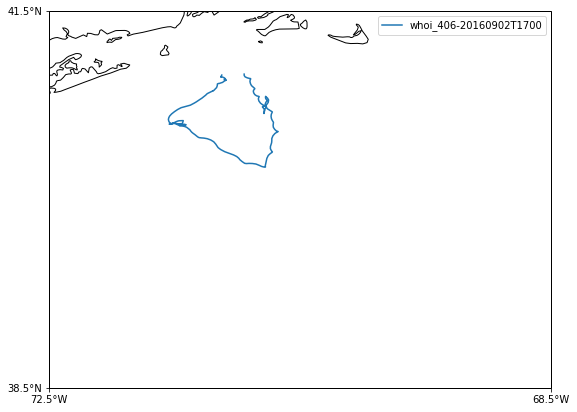

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


def make_map(extent):
    fig, ax = plt.subplots(
        figsize=(9, 9),
        subplot_kw=dict(projection=ccrs.PlateCarree())
    )
    ax.coastlines(resolution='10m')
    ax.set_extent(extent)

    ax.set_xticks([extent[0], extent[1]], crs=ccrs.PlateCarree())
    ax.set_yticks([extent[2], extent[3]], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    return fig, ax


dx = dy = 0.5
extent = kw['min_lon']-dx, kw['max_lon']+dx, kw['min_lat']+dy, kw['max_lat']+dy

fig, ax = make_map(extent)
for glider, df in dfs.items():
    ax.plot(df['longitude'], df['latitude'], label=glider)

leg = ax.legend()

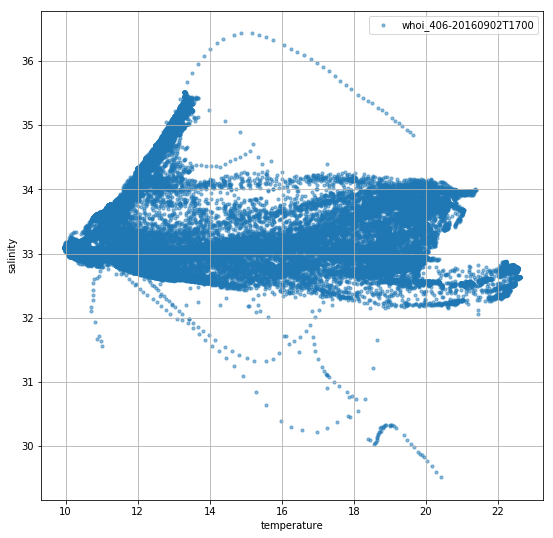

In [28]:
def glider_scatter(df, ax, glider):
    ax.scatter(df['temperature'], df['salinity'],
               s=10, alpha=0.5, label=glider)

fig, ax = plt.subplots(figsize=(9, 9))
ax.set_ylabel('salinity')
ax.set_xlabel('temperature')
ax.grid(True)

for glider, df in dfs.items():
    glider_scatter(df, ax, glider)

leg = ax.legend()

## Extras

### OPeNDAP response

In [29]:
e.constraints = None
e.protocol = 'tabledap'

opendap_url = e.get_download_url(
    dataset_id='whoi_406-20160902T1700',
    response='opendap',
)

print(opendap_url)

https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700


In [30]:
from netCDF4 import Dataset


with Dataset(opendap_url) as nc:
    print(nc.summary)

Slocum glider dataset gathered as part of the TEMPESTS (The Experiment to Measure and Predict East coast STorm Strength), funded by NOAA through CINAR (Cooperative Institute for the North Atlantic Region).


### netCDF "file-like" to xarray

`open_dataset` will download a temporary file,
so be careful with the constraints to avoid downloading several gigabytes!

In [31]:
e.dataset_id = 'cp_336-20170116T1254'
e.response = 'nc'
e.variables = common_variables
e.constraints = constraints

download_url = e.get_download_url()

In [32]:
import requests


def humansize(nbytes):
    suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
    k = 0
    while nbytes >= 1024 and k < len(suffixes)-1:
        nbytes /= 1024.
        k += 1
    f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
    return '%s %s' % (f, suffixes[k])

r = requests.head(download_url)
nbytes = float(r.headers['Content-Length'])
humansize(nbytes)

'599.82 KB'

That is the uncompressed size, we are OK because the download will be less than that, `ERDDAP` streams gzip'ed data.

In [33]:
r.headers['Content-Encoding']

'gzip'

In [34]:
ds = e.to_xarray(decode_times=False)

ds

<xarray.Dataset>
Dimensions:          (row: 16232)
Coordinates:
    lat_uv           (row) float64 ...
    time_uv          (row) float64 ...
    lon_uv           (row) float64 ...
Dimensions without coordinates: row
Data variables:
    precise_lon      (row) float64 ...
    longitude        (row) float64 ...
    temperature_qc   (row) float32 ...
    latitude         (row) float64 ...
    precise_lat      (row) float64 ...
    density_qc       (row) float32 ...
    u                (row) float64 ...
    pressure_qc      (row) float32 ...
    density          (row) float32 ...
    precise_time_qc  (row) float32 ...
    precise_time     (row) float64 ...
    temperature      (row) float32 ...
    conductivity_qc  (row) float32 ...
    latitude_qc      (row) float32 ...
    salinity         (row) float32 ...
    pressure         (row) float32 ...
    lon_uv_qc        (row) float32 ...
    v                (row) float64 ...
    v_qc             (row) float32 ...
    lat_uv_qc        (row)

In [35]:
ds['temperature']

<xarray.DataArray 'temperature' (row: 16232)>
array([14.3976, 14.4236, 14.4596, ...,  4.4004,  4.3975,  4.3978],
      dtype=float32)
Coordinates:
    lat_uv   (row) float64 ...
    time_uv  (row) float64 ...
    lon_uv   (row) float64 ...
Dimensions without coordinates: row
Attributes:
    _ChunkSizes:          1
    actual_range:         [ 0.     17.2652]
    ancillary_variables:  temperature_qc
    colorBarMaximum:      32.0
    colorBarMinimum:      0.0
    coordinates:          time lat lon depth
    instrument:           instrument_ctd
    ioos_category:        Temperature
    long_name:            Sea Water Temperature
    observation_type:     measured
    platform:             platform
    source_variable:      sci_water_temp
    standard_name:        sea_water_temperature
    units:                degree_Celsius
    valid_max:            40.0
    valid_min:            -5.0

In [36]:
import numpy as np


data = ds['temperature'].values
depth = ds['depth'].values

mask = ~np.ma.masked_invalid(data).mask

In [37]:
data = data[mask]
depth = depth[mask]
lon = ds['longitude'].values[mask]
lat = ds['latitude'].values[mask]

In [38]:
import warnings


with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    mask = depth <= 5

data = data[mask]
depth = depth[mask]
lon = lon[mask]
lat = lat[mask]

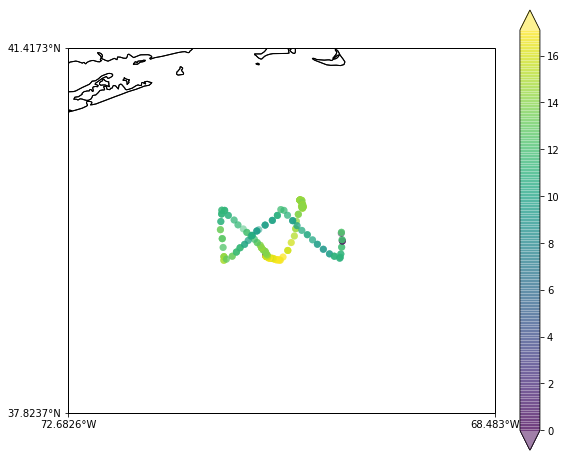

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


dx = dy = 1.5
extent = (
    ds.geospatial_lon_min-dx, ds.geospatial_lon_max+dx,
    ds.geospatial_lat_min-dy, ds.geospatial_lat_max+dy
)
fig, ax = make_map(extent)

cs = ax.scatter(lon, lat, c=data, s=50, alpha=0.5, edgecolor='none')
cbar = fig.colorbar(cs, orientation='vertical',
                    fraction=0.1, shrink=0.9, extend='both')
ax.coastlines('10m');

Or iris if the data is easier to navigate via the CF conventions data model.

In [40]:
import warnings

# Iris warnings are quire verbose!
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cubes = e.to_iris()

print(cubes)

0: latitude Variable Quality Flag / (1) (-- : 16232)
1: sea_water_electrical_conductivity / (S m-1) (-- : 16232)
2: longitude / (degrees)               (-- : 16232)
3: longitude / (degrees)               (-- : 16232)
4: sea_water_practical_salinity / (unknown) (-- : 16232)
5: longitude Variable Quality Flag / (1) (-- : 16232)
6: latitude / (degrees)                (-- : 16232)
7: sea_water_pressure / (dbar)         (-- : 16232)
8: latitude / (degrees)                (-- : 16232)
9: eastward_sea_water_velocity / (m s-1) (-- : 16232)
10: northward_sea_water_velocity / (m s-1) (-- : 16232)
11: sea_water_density / (kg/m^3)        (-- : 16232)
12: precise_time Variable Quality Flag / (1) (-- : 16232)
13: time / (seconds since 1970-01-01T00:00:00Z) (-- : 16232)
14: sea_water_temperature / (degree_Celsius) (-- : 16232)


In [41]:
cubes.extract_strict('sea_water_pressure')

Sea Water Pressure (dbar),--
Shape,16232
Attributes,
Conventions,"Unidata Dataset Discovery v1.0, COARDS, CF-1.6"
Easternmost_Easting,-69.98303682074565
Metadata_Conventions,"Unidata Dataset Discovery v1.0, COARDS, CF-1.6"
Northernmost_Northing,39.91726417227544
Southernmost_Northing,39.32370673037986
Westernmost_Easting,-71.18259602604894
_ChunkSizes,1
acknowledgement,Funding provided by the National Science Foundation. Glider deployed by...
